<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/SmartKitchen/blob/main/Experiment/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa

In [ ]:
import pickle

device = 'cpu'
print("device=", device)

device= cpu


In [ ]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [ ]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [ ]:
batch=1
audio, samplerate = librosa.load("./ACDC - Back In Black Intro.wav", mono=False, sr=None, offset=6)
print(audio.shape)
print(audio)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

(2, 882000)
[[-0.00158691  0.00073242  0.00228882 ...  0.10690308  0.0960083
   0.0760498 ]
 [-0.00119019  0.00140381  0.00283813 ...  0.13677979  0.14141846
   0.1303711 ]]


In [ ]:
batch=1
audio, samplerate = librosa.load("t.wav", mono=False, sr=None, offset=6)
print(type(audio))
print(type(audio[0]))
print(audio.shape)
print(audio)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2, 882000)
[[-0.00158691  0.00073242  0.00228882 ...  0.10690308  0.0960083
   0.0760498 ]
 [-0.00119019  0.00140381  0.00283813 ...  0.13677979  0.14141846
   0.1303711 ]]


In [ ]:
batch=1
t = []
audio, samplerate = librosa.load("./temp.wav", mono=False, sr=None)
audio = audio.reshape(1, -1)

audio[0,:]/=np.abs(audio[0,:]).max()
#audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension
#X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

In [ ]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()

Ypred=model(X_train)

#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)

Y=X_train[:,:,:outputlen]  #the target signal with same length as model output

print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 26626
Input X.shape= torch.Size([1, 1, 27115])
Target Y.shape= torch.Size([1, 1, 26626])
Target Y= tensor([[[0.0367, 0.0367, 0.0367,  ..., 0.0947, 0.0947, 0.0947]]])
Y.type()= torch.FloatTensor


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";

#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)

#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(4000):
        #distortions: shift and noise:
        #"""
        Xlast=X_train[:,:,-1].clone()
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone()
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
        #"""
        Ypred=model(X_train+torch.randn(X_train.size())*0.05)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[-0.0132, -0.0153, -0.0232,  ..., -0.0208, -0.0173, -0.0162]]],
       grad_fn=<ConvolutionBackward0>)
0 0.027758734300732613
10 0.026165561750531197
20 0.02440965361893177
30 0.02183132991194725
40 0.017852146178483963
50 0.01551765576004982
60 0.014783268794417381
70 0.013169118203222752
80 0.011024716310203075
90 0.010491793043911457
100 0.010206508450210094
110 0.00936244148761034
120 0.009094426408410072
130 0.008858958259224892
140 0.008747025392949581
150 0.008339772000908852
160 0.007991796359419823
170 0.0077091786079108715
180 0.007597702089697123
190 0.007200333289802074
200 0.0069850729778409
210 0.007038735318928957
220 0.006788379047065973
230 0.006442962680011988
240 0.006302008405327797
250 0.006284560076892376
260 0.005910929292440414
270 0.005774205084890127
280 0.005717387422919273
290 0.005529755726456642
300 0.005340817384421825
310 0.005232455674558878
320 0.005113787017762661
330 0.004936278332024813
340 0.00498798256739974
350 0.00482536153867840

ww= OrderedDict([('conv1.weight', tensor([[[-0.0215, -0.0151,  0.0075,  ...,  0.0214,  0.0084,  0.0229]],

        [[ 0.0044, -0.0058,  0.0161,  ..., -0.0090, -0.0068, -0.0171]],

        [[-0.0079,  0.0107,  0.0199,  ...,  0.0122,  0.0099,  0.0153]],

        ...,

        [[ 0.0477,  0.0322,  0.0256,  ..., -0.0154, -0.0075, -0.0110]],

        [[ 0.0308,  0.0061,  0.0188,  ..., -0.0065, -0.0120, -0.0097]],

        [[ 0.0032,  0.0113, -0.0021,  ...,  0.0224,  0.0030,  0.0217]]])), ('conv1.bias', tensor([ 0.0195,  0.0103,  0.0105,  0.0286,  0.0202, -0.0060, -0.0234,  0.0012,
         0.0137,  0.0099,  0.0007,  0.0096, -0.0214, -0.0076,  0.0237,  0.0262,
        -0.0140,  0.0144, -0.0024,  0.0067,  0.0231, -0.0346, -0.0154, -0.0155,
         0.0040,  0.0235,  0.0182,  0.0034,  0.0007, -0.0064,  0.0064, -0.0069])), ('synconv1.weight', tensor([[[ 0.0123,  0.0044,  0.0085,  ...,  0.0227,  0.0054,  0.0266]],

        [[ 0.0006,  0.0103,  0.0058,  ..., -0.0135, -0.0082, -0.0094]],

        

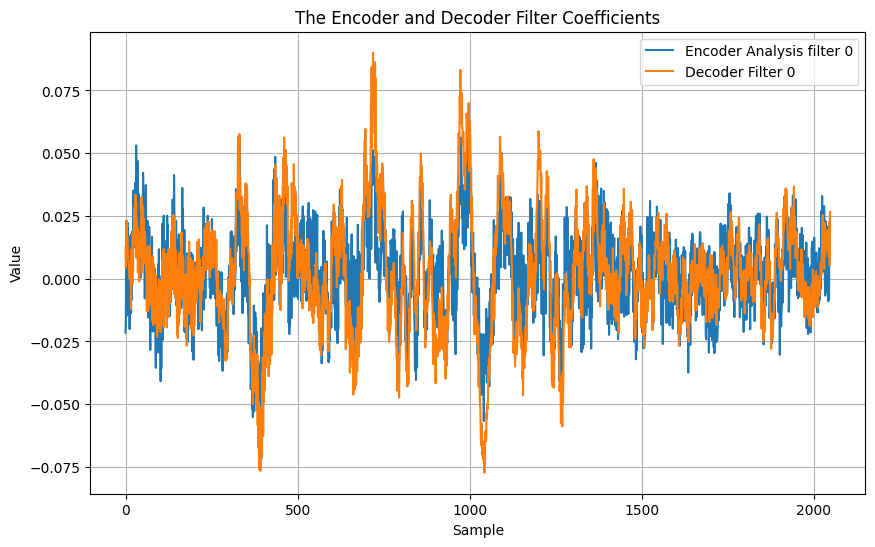

In [ ]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""

ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

predictions.shape= (1, 1, 26626)


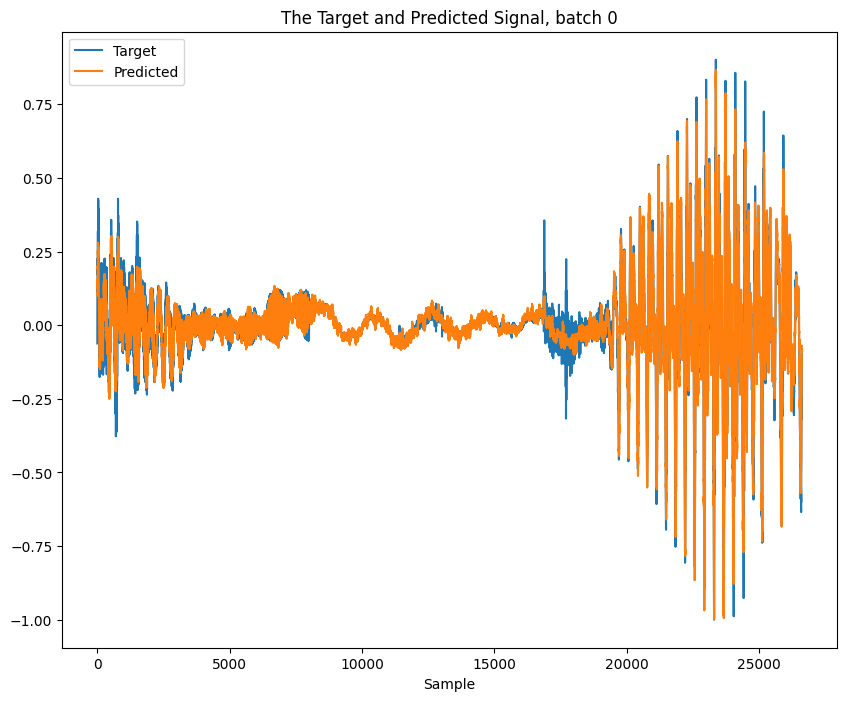

In [ ]:
#Test on training set:
Xnoise=(X_train+torch.randn(X_train.size())*0.05)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(Xnoise).cpu() # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()

Xnoise=Xnoise.detach()
Xnoise=np.array(Xnoise)
xnoise=Xnoise[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)

xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [ ]:
import IPython.display as ipd
display(ipd.Audio(xnoise, rate=samplerate));

In [ ]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

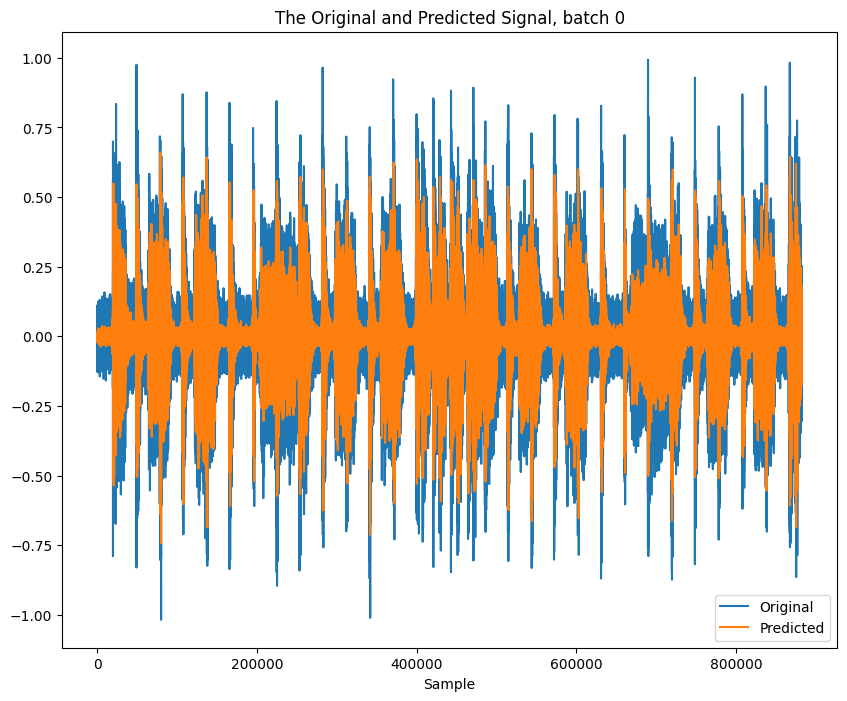

In [ ]:
#Test on Verification set:
X_test_shifted_100 = nn.ConstantPad1d(100, 0)(X_test)
x=X_test_shifted_100+torch.from_numpy((np.random.normal(scale=0.04, size=X_test_shifted_100.shape))).float()
predictions=model(x).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(x[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [ ]:
display(ipd.Audio(x[:,0,:], rate=samplerate));


In [ ]:
display(ipd.Audio(xrek, rate=samplerate));
